In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from functools import lru_cache
import matplotlib.pyplot as plt

/var/folders/gr/g6k4s8t13n98c8bw4ywdpxrr0000gn/T/ipykernel_35870/4292185403.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
### PG&E ###
# Loading and inspecting data
@lru_cache(maxsize=128)
def load_pge_data():
    pge_data = gpd.read_file('../data/raw/ICADisplay.gdb', driver='fileGDB', layer='LineDetail')
    return pge_data

pge_cached = load_pge_data()


Index(['FeederId', 'FeederName', 'Globalid', 'CSV_LineSection',
       'ICA_Analysis_Date', 'LoadCapacity_kW', 'GenCapacity_kW',
       'GenericPVCapacity_kW', 'GenCapacity_no_OpFlex_kW',
       'GenericCapacity_no_OpFlex_kW', 'Shape_Length', 'geometry'],
      dtype='object')
Total available load capacity: 1131124970 kW
Average load capacity: 1583.3637372774472 kW


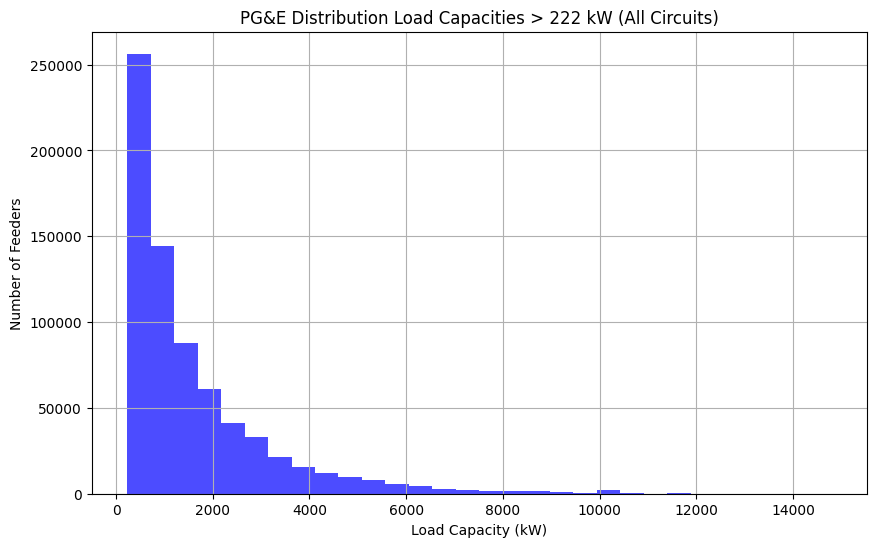

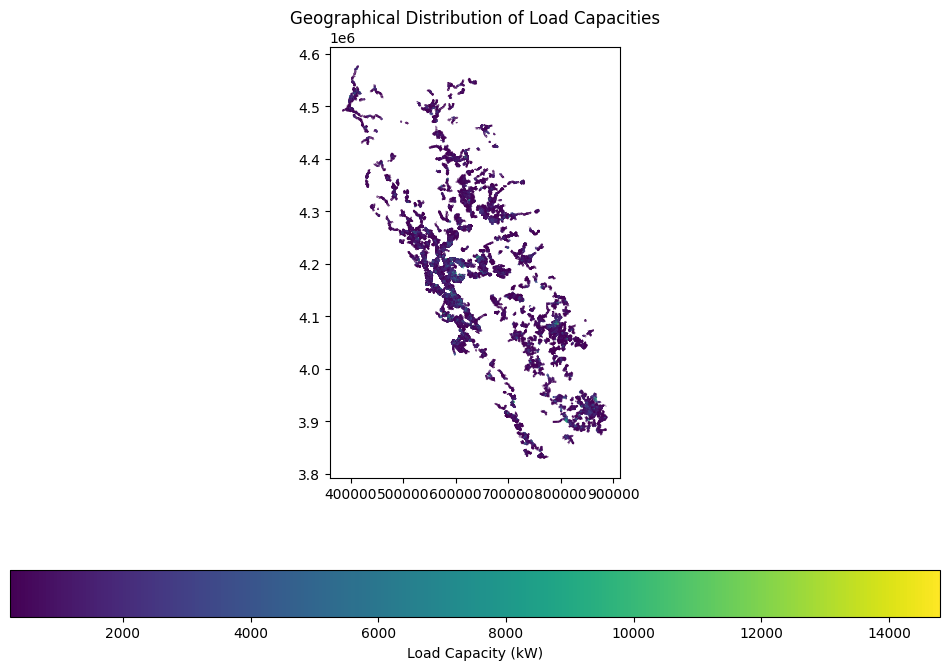

In [139]:
print(pge_cached.keys())

# Filter by amount of capacity available
load_threshold = 222 # kW
mask = pge_cached['LoadCapacity_kW'] >= load_threshold
pge = pge_cached[mask]

# Total available load capacity
total_capacity = pge['LoadCapacity_kW'].sum()
print(f"Total available load capacity: {total_capacity} kW")

# Average load capacity
average_capacity = pge['LoadCapacity_kW'].mean()
print(f"Average load capacity: {average_capacity} kW")

# Remaining capacity
plt.figure(figsize=(10, 6))
plt.hist(pge['LoadCapacity_kW'], bins=30, color='blue', alpha=0.7)
plt.title('PG&E Distribution Load Capacities > 222 kW (All Circuits)')
plt.xlabel('Load Capacity (kW)')
plt.ylabel('Number of Feeders')
plt.grid(True)
plt.show()

# Geographic distribution of load capacities
fig, ax = plt.subplots(figsize=(12, 8))
pge.plot(column='LoadCapacity_kW', ax=ax, legend=True,
                  legend_kwds={'label': "Load Capacity (kW)", 'orientation': "vertical"})
plt.title('Geographical Distribution of Load Capacities')
plt.show()

# Driving question: 
# Where is there still capacity?

# Given a load profiles, if we electrify it, does it exceed the capacity available on that circuit?

# Where can we electrify all load without exceeding the distribution capacity available on the circuit?

# Which of these areas are of low socio-economic status?

# Where will there be non-cost barriers (infrastructure blockers from PGE capacity) to electrifying load under different load profiles?

# We have "representative" load profiles, ie 10,000, not millions of customers. How do we upsample that to make projections about where distribution capacity will be exceeded

# Review data sources from: https://haas.berkeley.edu/wp-content/uploads/WP327.pdf

# Review prior code from Eleanor and Victor here: https://github.com/eleanor-adachi/ccai-dac-grid

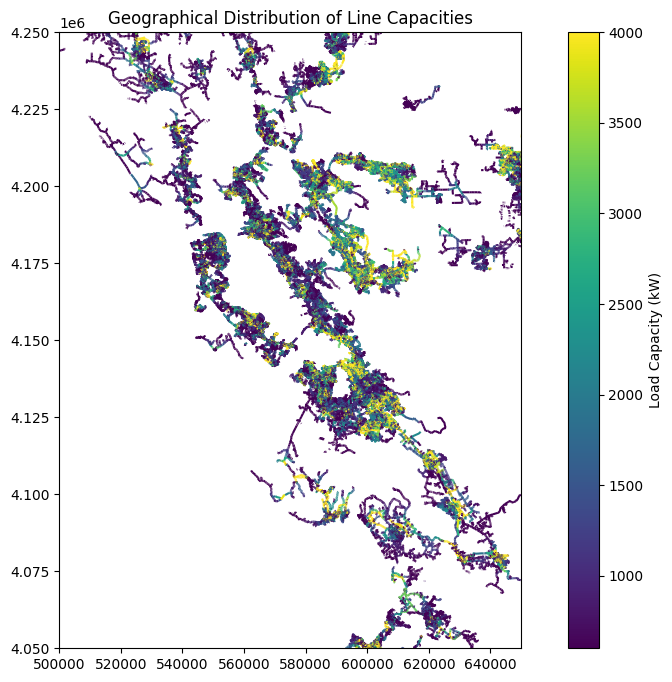

In [145]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import geopandas as gpd

# Assuming 'pge' is your GeoDataFrame with the load capacity data

# Define the range of load capacities you want to display
min_capacity = 600  # Minimum load capacity
max_capacity = 4000  # Maximum load capacity

# Create a normalization object that will scale the load capacity values
norm = Normalize(vmin=min_capacity, vmax=max_capacity)

# Choose a colormap for the plot
cmap = cm.viridis  # You can choose any other colormap that you prefer

fig, ax = plt.subplots(figsize=(12, 8))

# Set the x and y limits to the extents of the Bay Area
ax.set_xlim(500000, 650000)
ax.set_ylim(4.05*10**6, 4.25*10**6)

# Plot using the specified colormap and normalization
pge.plot(column='LoadCapacity_kW', ax=ax, legend=True,
         legend_kwds={'label': "Load Capacity (kW)", 'orientation': "vertical"},
         cmap=cmap, norm=norm)

plt.title('Geographical Distribution of Line Capacities')
plt.show()


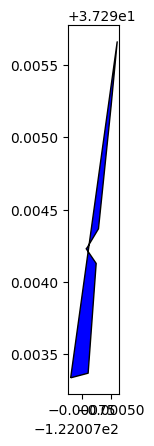

/var/folders/gr/g6k4s8t13n98c8bw4ywdpxrr0000gn/T/ipykernel_35870/2082433517.py:28: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = gdf.geometry.centroid.iloc[0]


GeocoderInsufficientPrivileges: Non-successful status code 403

In [146]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon
from geopy.geocoders import Nominatim
from shapely.geometry import Point

# Coordinates of the polygon vertices
coordinates = [
    (-122.007852, 37.293338), (-122.0077, 37.29337), (-122.00763, 37.29413), 
    (-122.007717, 37.294232), (-122.007708, 37.29424), (-122.00761, 37.29437), 
    (-122.007568, 37.294693), (-122.0075, 37.29522), (-122.007447, 37.295665), 
    # Add all other coordinates in the same manner...
    (-122.007852, 37.293338)  # Closing the polygon by repeating the first point
]

# Create a Polygon object
polygon = Polygon(coordinates)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(index=[0], crs='EPSG:4326', geometry=[polygon])

# Plotting the polygon
fig, ax = plt.subplots()
gdf.plot(ax=ax, color='blue', edgecolor='black')
plt.show()

# Get the centroid of the polygon
centroid = gdf.geometry.centroid.iloc[0]

# Initialize the Nominatim API to get address
geolocator = Nominatim(user_agent="geoapiExercises")

# Get the address by querying the centroid of the polygon
location = geolocator.reverse((centroid.y, centroid.x), exactly_one=True)
address = location.address

# Print the address
print("Address of the centroid:", address)


In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

# Load and prepare the data
circinfo = gpd.read_file("ICADisplay.gdb", layer="FeederDetail", ignore_geometry=True)
subinfo = gpd.read_file("ICADisplay.gdb", layer="Substations", ignore_geometry=True)
circload = gpd.read_file("ICADisplay.gdb", layer="FeederLoadProfile", ignore_geometry=True)
subload = gpd.read_file("ICADisplay.gdb", layer="SubstationLoadProfile", ignore_geometry=True)

# Data Processing
circica = circinfo[['FeederId', 'CSV_LineSection', 'LoadCapacity_kW']].groupby('FeederId').agg(
    IC_LoadLimit_Rall_kW=pd.NamedAgg(column='LoadCapacity_kW', aggfunc='max')
).reset_index()
circica['FeederId'] = pd.Categorical(circica['FeederId'], categories=pd.Categorical(circica['FeederId']).categories[::-1], ordered=True)

# Save to CSV
circica.to_csv("data_clean/circica.csv", index=False)
circica.dtypes.to_frame().T.to_csv("data_clean/circica_cls.csv", index=False)

# Plotting
plt.figure(figsize=(6, 4))
plt.bar(circica['FeederId'], circica['IC_LoadLimit_Rall_kW'], color='lightblue')
plt.xlabel('Circuit')
plt.ylabel('Max Remaining Load Capacity (kW)')
plt.savefig("figures/PGEcircmaxload.png")
plt.close()

# Creating new DataFrame for month-hour data
mh = pd.DataFrame({
    'Month': np.repeat(np.arange(1, 13), 24),
    'Hour': np.tile(np.arange(24), 12)
})
mh['mhid'] = np.arange(len(mh))

# Merge and clean data
circload['Month'] = pd.Categorical(circload['MonthHour'].str.slice(0, 2).astype(int))
circload['Hour'] = pd.Categorical(circload['MonthHour'].str.slice(3, 5).astype(int))
circload = circload.rename(columns={'Light': 'l_kW', 'High': 'h_kW'})
circload = circload.merge(mh, on=['Month', 'Hour'], how='outer', sort=True)

# Additional cleaning and merging
circinfo['TotCust'] = circinfo[['ResCust', 'ComCust', 'IndCust', 'AgrCust', 'OthCust']].sum(axis=1)
for col in ['ResCust', 'ComCust', 'IndCust', 'AgrCust', 'OthCust']:
    circinfo[col+'_pct'] = circinfo[col] / circinfo['TotCust'] * 100

circload = circload.merge(
    circinfo[['Substation', 'FeederID', 'Feeder_Name', 'Nominal_Voltage', 'Load_Profile',
              'ResCust', 'ComCust', 'IndCust', 'AgrCust', 'OthCust', 'TotCust',
              'Existing_DG', 'Queued_DG', 'Total_DG']],
    on='FeederID', how='left'
)

# Substation and mapping operations
cz = gpd.read_file("../climatezones/California_Building_Climate_Zones-shp", layer="Building_Climate_Zones")
cz['BZone'] = cz['BZone'].astype(int).astype(str)
ctys = gpd.read_file("../geo/tl_2010_06_county10", layer="tl_2010_06_county10")

# Transform CRS
subinfo = subinfo.to_crs(epsg=3310)
ctys = ctys.to_crs(epsg=3310)

# Join operations and centroid calculation
subincz = gpd.sjoin(subinfo, cz, how="inner", predicate='within')
subincz = gpd.sjoin(subincz, ctys[['COUNTYFP10', 'NAME10', 'geometry']], how="inner", predicate='within')
subinczcoord = gpd.GeoDataFrame(
    subincz.drop(columns=['geometry']).groupby(['BZone', 'NAME10', 'COUNTYFP10']).agg(
        {'X': 'mean', 'Y': 'mean'}
    ).reset_index(),
    geometry=gpd.points_from_xy(subincz['X'], subincz['Y']),
    crs="EPSG:3310"
).to_crs(epsg=4326)

subinczcoord['ll'] = subinczcoord.apply(lambda row: f"{row['Y']},{row['X']}", axis=1)
subinczcoord.to_csv("subinczll.csv", index=False)

# Final plotting with `matplotlib`
fig, ax = plt.subplots(figsize=(10, 6))
ctys.plot(ax=ax, color='none', edgecolor='gray', legend=True)
cz.plot(ax=ax, column='BZone', cmap='viridis', legend=True)
subinfo.plot(ax=ax, color='red', marker='o', label='Substation', legend=True)
plt.legend()
plt.savefig("subinczboth_nos.png")
plt.close()


SyntaxError: incomplete input (999353337.py, line 72)

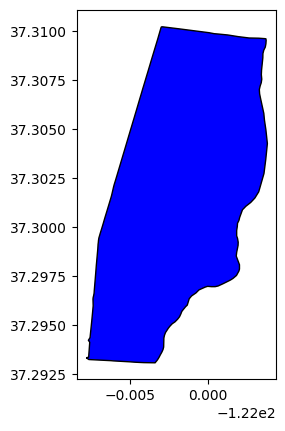

/var/folders/gr/g6k4s8t13n98c8bw4ywdpxrr0000gn/T/ipykernel_35870/3452601282.py:87: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = gdf.geometry.centroid.iloc[0]


GeocoderInsufficientPrivileges: Non-successful status code 403

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon
from geopy.geocoders import Nominatim
from shapely.geometry import Point

coordinates = [
    (-122.007852, 37.293338), (-122.0077, 37.29337), (-122.00763, 37.29413),
    (-122.007717, 37.294232), (-122.007708, 37.29424), (-122.00761, 37.29437),
    (-122.007568, 37.294693), (-122.0075, 37.29522), (-122.007447, 37.295665),
    (-122.00741, 37.29599), (-122.007412, 37.296058), (-122.007419, 37.296263),
    (-122.00742, 37.296291), (-122.007422, 37.296332), (-122.007409, 37.296419),
    (-122.007384, 37.296498), (-122.007352, 37.296627), (-122.007347, 37.296676),
    (-122.00734, 37.296764), (-122.007313, 37.297021), (-122.007276, 37.297375),
    (-122.007233, 37.297794), (-122.007208, 37.298052), (-122.007183, 37.29827),
    (-122.007115, 37.29888), (-122.007111, 37.298924), (-122.007094, 37.299143),
    (-122.007084, 37.299193), (-122.007076, 37.299255), (-122.007068, 37.299329),
    (-122.007043, 37.299454), (-122.006995, 37.299585), (-122.006956, 37.299692),
    (-122.006847, 37.299972), (-122.006766, 37.300186), (-122.006663, 37.30047),
    (-122.00653, 37.300817), (-122.006423, 37.301099), (-122.00626, 37.30153),
    (-122.006234, 37.301607), (-122.006213, 37.301672), (-122.006099, 37.302065),
    (-122.006054, 37.302197), (-122.005999, 37.302335), (-122.005927, 37.302525),
    (-122.005696, 37.303142), (-122.005506, 37.30365), (-122.005402, 37.303925),
    (-122.005094, 37.304751), (-122.004991, 37.305027), (-122.004959, 37.305109),
    (-122.004866, 37.305358), (-122.004835, 37.305441), (-122.00481, 37.305505),
    (-122.004737, 37.305701), (-122.004713, 37.305766), (-122.004652, 37.305927),
    (-122.004472, 37.306414), (-122.004412, 37.306576), (-122.004373, 37.306678),
    (-122.00426, 37.306982), (-122.004223, 37.307084), (-122.004172, 37.307216),
    (-122.004021, 37.307615), (-122.003971, 37.307749), (-122.003917, 37.307889),
    (-122.003759, 37.308311), (-122.003707, 37.308452), (-122.003255, 37.309641),
    (-122.003196, 37.309805), (-122.003058, 37.310184), (-122.003036, 37.310224),
    (-122.00296, 37.31023), (-122.00193, 37.31013), (-121.99998, 37.30993),
    (-121.99965, 37.30988), (-121.99936, 37.30986), (-121.998773, 37.309814),
    (-121.998111, 37.30973), (-121.997518, 37.309671), (-121.997411, 37.30966),
    (-121.996789, 37.309649), (-121.996402, 37.309627), (-121.996325, 37.309617),
    (-121.996311, 37.309535), (-121.996325, 37.309365), (-121.996366, 37.309194),
    (-121.996462, 37.30904), (-121.996517, 37.308864), (-121.996524, 37.308645),
    (-121.99654, 37.308519), (-121.996606, 37.308013), (-121.996619, 37.307787),
    (-121.996592, 37.307557), (-121.996626, 37.307375), (-121.996695, 37.307211),
    (-121.996749, 37.307029), (-121.996729, 37.306804), (-121.99666, 37.30654),
    (-121.99646, 37.30581), (-121.996441, 37.305653), (-121.996418, 37.305463),
    (-121.996328, 37.30498), (-121.996232, 37.304271), (-121.996334, 37.303469),
    (-121.99645, 37.302744), (-121.996787, 37.30181), (-121.997034, 37.301491),
    (-121.997126, 37.301413), (-121.997302, 37.301265), (-121.997618, 37.301067),
    (-121.997719, 37.300982), (-121.997831, 37.300891), (-121.99801, 37.300501),
    (-121.998058, 37.300347), (-121.998147, 37.300204), (-121.998161, 37.300045),
    (-121.998202, 37.299831), (-121.998202, 37.299562), (-121.998147, 37.29943),
    (-121.998105, 37.299238), (-121.998112, 37.299078), (-121.998149, 37.298927),
    (-121.998201, 37.298726), (-121.998229, 37.298529), (-121.998091, 37.298232),
    (-121.998022, 37.298084), (-121.998022, 37.297869), (-121.998056, 37.29777),
    (-121.998214, 37.29754), (-121.998441, 37.297386), (-121.998552, 37.29733),
    (-121.99862, 37.297298), (-121.999094, 37.297111), (-121.999396, 37.297001),
    (-121.999582, 37.296968), (-121.999816, 37.296967), (-122.000064, 37.296984),
    (-122.000091, 37.296978), (-122.000222, 37.296945), (-122.000621, 37.296802),
    (-122.000813, 37.296648), (-122.001069, 37.296508), (-122.001097, 37.296492),
    (-122.001248, 37.296349), (-122.001372, 37.296025), (-122.001482, 37.295943),
    (-122.001522, 37.295902), (-122.001634, 37.295794), (-122.001723, 37.295701),
    (-122.001778, 37.295586), (-122.001868, 37.295432), (-122.001992, 37.295306),
    (-122.002164, 37.295168), (-122.002317, 37.295086), (-122.002336, 37.295075),
    (-122.002474, 37.29496), (-122.002592, 37.294844), (-122.002638, 37.294785),
    (-122.00277, 37.294625), (-122.002838, 37.294476), (-122.002873, 37.294339),
    (-122.002887, 37.293883), (-122.002929, 37.293757), (-122.003004, 37.293625),
    (-122.003046, 37.293565), (-122.003094, 37.293499), (-122.003183, 37.293361),
    (-122.00328, 37.293235), (-122.003306, 37.293209), (-122.003331, 37.293183),
    (-122.003397, 37.29312), (-122.003408, 37.293107), (-122.003433, 37.293081),
    (-122.003682, 37.293084), (-122.00415, 37.29309), (-122.00443, 37.2931),
    (-122.00468, 37.29311), (-122.004749, 37.293113), (-122.00496, 37.293125),
    (-122.00503, 37.29313), (-122.005276, 37.293141), (-122.006014, 37.293174),
    (-122.00613, 37.29318), (-122.00626, 37.29319), (-122.006489, 37.293199),
    (-122.00718, 37.293227), (-122.00741, 37.293237), (-122.007502, 37.29324),
    (-122.007685, 37.293248), (-122.007745, 37.29328), (-122.00777, 37.293293),
    (-122.007852, 37.293338)  # Closing the polygon by repeating the first point
]

# Create a Polygon object
polygon = Polygon(coordinates)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(index=[0], crs='EPSG:4326', geometry=[polygon])

# Plotting the polygon
fig, ax = plt.subplots()
gdf.plot(ax=ax, color='blue', edgecolor='black')
plt.show()

# Get the centroid of the polygon
centroid = gdf.geometry.centroid.iloc[0]

# Initialize the Nominatim API to get address
geolocator = Nominatim(user_agent="geoapiExercises")

# Get the address by querying the centroid of the polygon
location = geolocator.reverse((centroid.y, centroid.x), exactly_one=True)
address = location.address

# Print the address
print("Address of the centroid:", address)


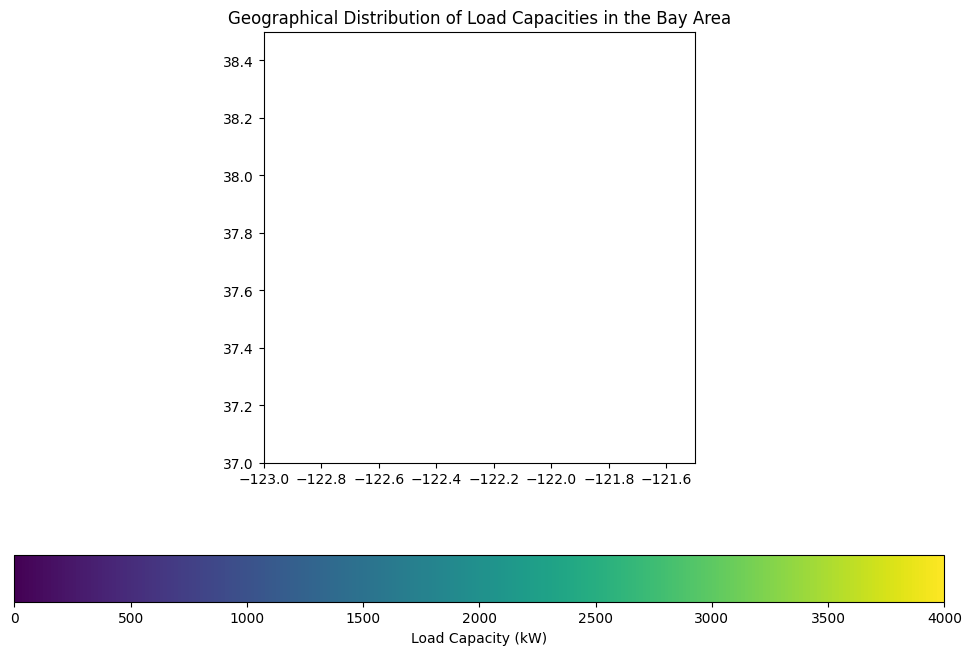

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import geopandas as gpd

# Assuming 'pge' is your GeoDataFrame with the load capacity data

# Define the range of load capacities you want to display
min_capacity = 0  # Set your minimum load capacity
max_capacity = 4000  # Set your maximum load capacity

# Create a normalization object that will scale the load capacity values
norm = Normalize(vmin=min_capacity, vmax=max_capacity)

# Choose a colormap for the plot
cmap = cm.viridis  # You can choose any other colormap that you prefer

# Define the geographical extents for the Bay Area using the format (minx, maxx, miny, maxy)
# These are approximate and you may need to adjust them to get the exact area you want
bay_area_extent = (-123.0, -121.5, 37.0, 38.5) # West, East, South, North bounds

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot using the specified colormap and normalization
pge.plot(column='LoadCapacity_kW', ax=ax, legend=True,
         legend_kwds={'label': "Load Capacity (kW)", 'orientation': "horizontal"},
         cmap=cmap, norm=norm)

# Set the x and y limits to the extents of the Bay Area
ax.set_xlim(bay_area_extent[0], bay_area_extent[1])
ax.set_ylim(bay_area_extent[2], bay_area_extent[3])

plt.title('Geographical Distribution of Load Capacities in the Bay Area')
plt.show()


In [ ]:
# If your data is in a CSV file and the geometry column needs to be converted:
# data = pd.read_csv("path_to_your_data.csv")
pge_cached['geometry'] = gpd.GeoSeries.from_wkt(pge_cached['geometry'])
gdf = gpd.GeoDataFrame(pge_cached, geometry='geometry')

# If your data is already in a geospatial format (like GeoJSON, Shapefile):
# gdf = gpd.read_file("path_to_your_geospatial_data.shp")

specific_circuit = gdf[gdf['FeederId'] == '012041134']

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
specific_circuit.plot(ax=ax, color='blue')  # You can customize the color
plt.title("Map of Circuit Coverage")
plt.show()


TypeError: Expected bytes or string, got MultiLineString

In [ ]:
# Important circuits
# Display specific details of circuits with available capacity
# The feeder load capacity indicates the amount of electrical power (measured in kilowatts, kW) that can be safely added to the feeder without exceeding its maximum capacity. 

load_threshold = 600 # kW
mask = pge_cached['LoadCapacity_kW'] >= load_threshold
pge = pge_cached[mask]
important_circuits = pge[['FeederId', 'FeederName', 'LoadCapacity_kW']]
print(f"Total circuits: {pge_cached['FeederId'].count()}")
print(f"Load threshold above 600 kW circuits: {important_circuits['FeederId'].count()}")
print(f"% of circuits above 600 kW load threshold: {round(important_circuits['FeederId'].count() / pge_cached['FeederId'].count() * 100)} %")
print(important_circuits.head())

Total circuits: 1232039
Load threshold above 600 kW circuits: 506012
Percent: 41 %
     FeederId         FeederName  LoadCapacity_kW
1   163692101  SALT SPRINGS 2101              950
3   012022211       CLAYTON 2211             2940
6   252241112     KINGSBURG 1112              790
8   012232109   NEWARK 21KV 2109             2600
13  182261103   BUENA VISTA 1103             1040


In [ ]:
# Check the general structure and presence of NaNs in the geometry column for the entire dataset
print(pge['geometry'].isnull().sum())
print(pge['geometry'].head())

# Specifically check the geometry for 'BUENA VISTA' circuit
print(specific_circuit['geometry'].isnull().sum())
print(specific_circuit['geometry'])

0
1     MULTILINESTRING ((747026.635 4261734.433, 7470...
3     MULTILINESTRING ((590111.155 4201648.613, 5901...
6     MULTILINESTRING ((806716.306 4046858.123, 8067...
8     MULTILINESTRING ((592147.575 4149681.763, 5921...
13    MULTILINESTRING ((621490.145 4057145.003, 6214...
Name: geometry, dtype: geometry
0
GeoSeries([], Name: geometry, dtype: geometry)


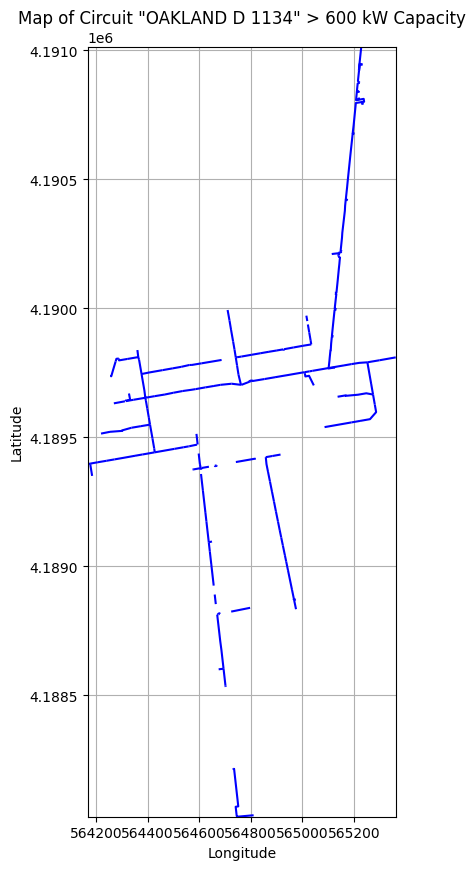

In [ ]:
import numpy as np

gdf = gpd.GeoDataFrame(pge_cached, geometry='geometry')
specific_circuit = gdf[gdf['FeederId'] == '012041134']

fig, ax = plt.subplots(figsize=(10, 10))
specific_circuit.plot(ax=ax, color='blue', edgecolor='k')

# Calculate bounds with a check for validity
bounds = specific_circuit.geometry.total_bounds
if np.all(np.isfinite(bounds)):  # Only set limits if all bounds are finite
    ax.set_xlim([bounds[0], bounds[2]])
    ax.set_ylim([bounds[1], bounds[3]])
else:
    print("Invalid bounds detected:", bounds)

plt.title('Map of Circuit "OAKLAND D 1134" > 600 kW Capacity')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()


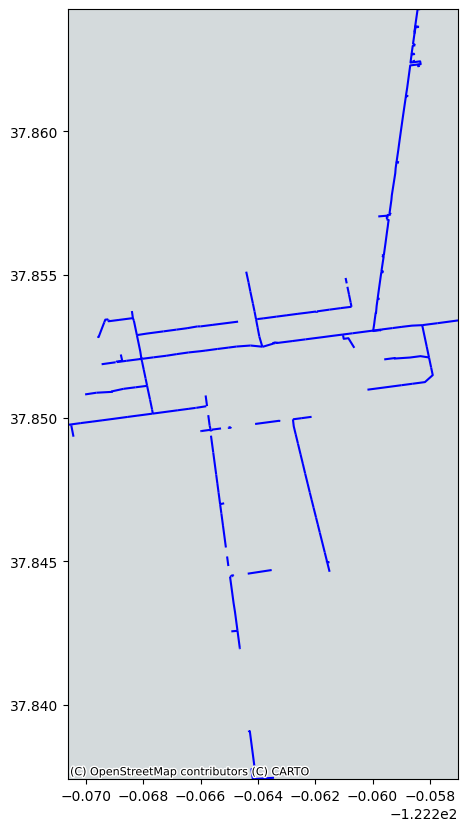

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np

# Assuming pge_cached is already loaded with the necessary data
gdf = gpd.GeoDataFrame(pge_cached, geometry='geometry')

# Ensure the data is in WGS 84 CRS for contextily
gdf = gdf.to_crs(epsg=4326)

# Filter the specific circuit
specific_circuit = gdf[gdf['FeederId'] == '012041134']

# Plot setup
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the specific circuit
specific_circuit.plot(ax=ax, color='blue', edgecolor='k')

# Check and process bounds
bounds = specific_circuit.total_bounds
if np.all(np.isfinite(bounds)):  # Check if all bounds are finite
    # Update axis limits
    ax.set_xlim([bounds[0], bounds[2]])
    ax.set_ylim([bounds[1], bounds[3]])
    
    # Convert to Web Mercator
    specific_circuit_mercator = specific_circuit.to_crs(epsg=3857)

    # Plot again in Mercator CRS for basemap compatibility
    specific_circuit_mercator.plot(ax=ax, color='blue', edgecolor='k')

    # Set a zoom level manually if desired, or let contextily auto-set it
    zoom_level = 16  # Adjust as needed for the right level of detail

    # Adding the basemap with streets visible
    # ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=zoom_level, dpi=300)
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=zoom_level)

    # ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=zoom_level)
else:
    print("Invalid bounds detected:", bounds)

# Additional plot formatting
plt.title('Map of Circuit "OAKLAND D 1134" > 600 kW Capacity')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()


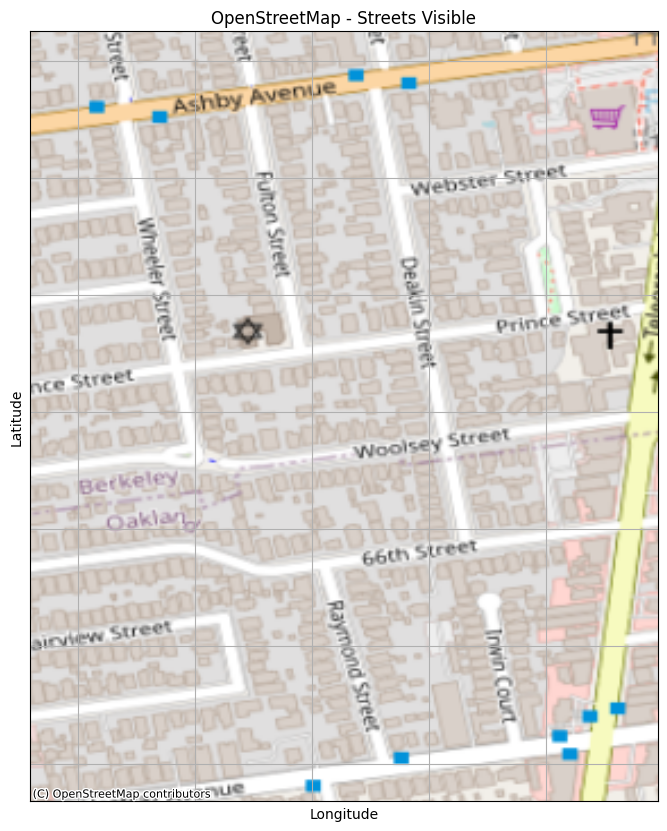

In [ ]:
import matplotlib.pyplot as plt
import contextily as ctx

# Define the area you want to plot with bounds (longitude/latitude)
# For example, these might be the bounds around the Oakland area
# These bounds would normally be determined by your specific data
west, south, east, north = -122.265410, 37.849677, -122.260046, 37.856250

# Create a figure and axis with Matplotlib
fig, ax = plt.subplots(figsize=(10, 10))

# Define the zoom level - higher numbers zoom in closer
zoom_level = 16

# Set the axis limits to the bounds
ax.set_xlim(west, east)
ax.set_ylim(south, north)

# Add the OpenStreetMap basemap
# Using the bounds defined above to center the map
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, 
                crs='EPSG:4326', zoom=zoom_level)

# Additional plot formatting, if desired
ax.set_title('OpenStreetMap - Streets Visible')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

# Hide the x and y axis tick marks
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

plt.show()


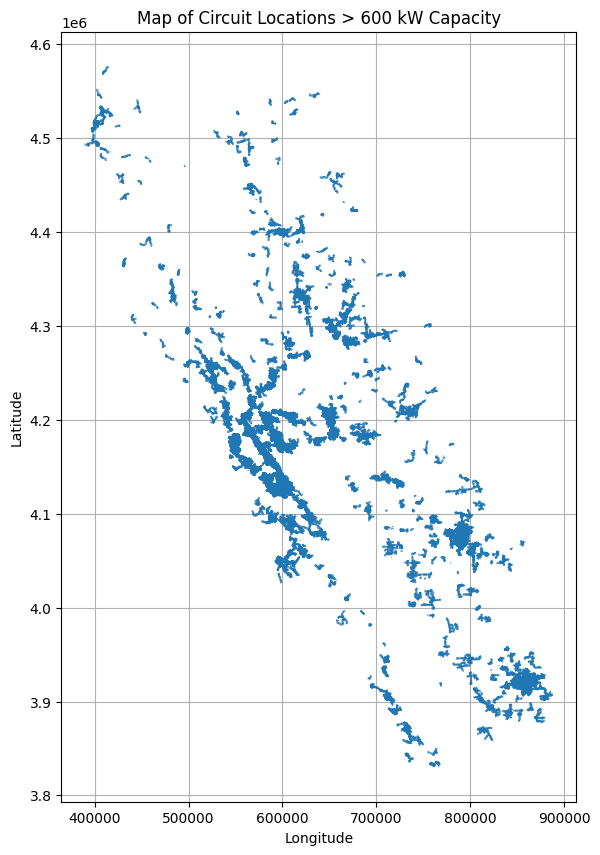

GeoSeries([], Name: geometry, dtype: geometry)


In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
pge.plot(ax=ax)
plt.title('Map of Circuit Locations > 600 kW Capacity')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

specific_circuit = pge[pge['FeederName'] == 'BUENA VISTA']
print(specific_circuit['geometry'])

In [ ]:
# BOTE match

# Heat Pump - 5kW
# At home charging - 7.2 kW
# Electric stove - 10 kW


270 / (5 + 10 + 7.2)




12.162162162162163

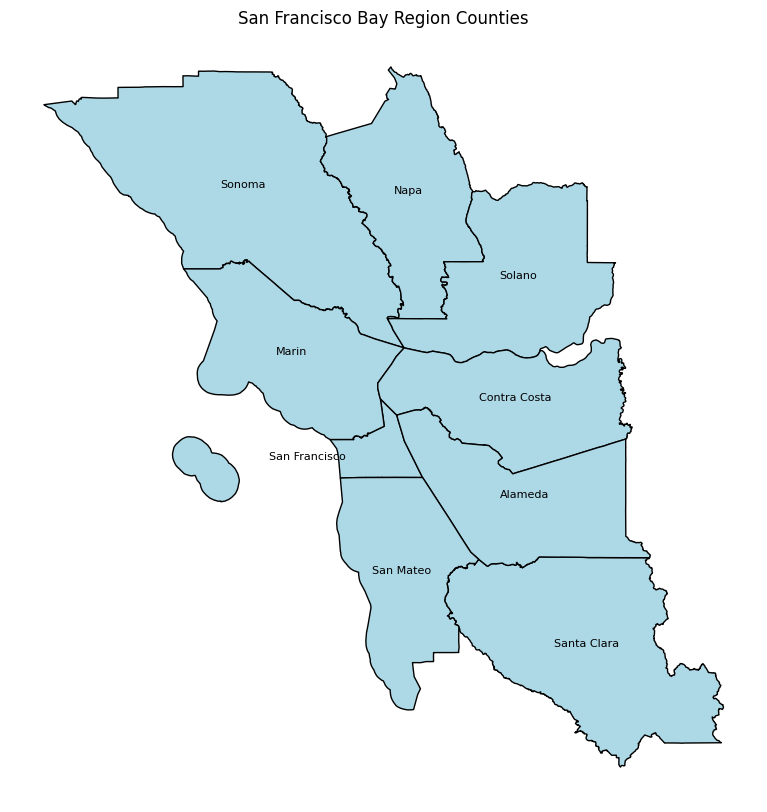

In [ ]:
### Get Bay Area region data ###
# https://opendata.mtc.ca.gov/datasets/MTC::san-francisco-bay-region-counties-1/about
region_county = gpd.read_file('../data/raw/region_county_5910830457166027147/region_county.shp')

# Map fips to county name because for some reason these are None in the shape file
fips_to_coname = {
    '001': 'Alameda',
    '013': 'Contra Costa',
    '041': 'Marin',
    '055': 'Napa',
    '075': 'San Francisco',
    '081': 'San Mateo',
    '085': 'Santa Clara',
    '095': 'Solano',
    '097': 'Sonoma'
}
region_county['coname'] = region_county['fipco'].map(fips_to_coname)
# print(region_county)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
region_county.plot(ax=ax, color='lightblue', edgecolor='black')

for idx, row in region_county.iterrows():
    ax.annotate(text=row['coname'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                horizontalalignment='center', fontsize=8, color='black')

ax.set_title('San Francisco Bay Region Counties')
ax.set_axis_off()
plt.show()

EPSG:3857
EPSG:4326


/Users/ana/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


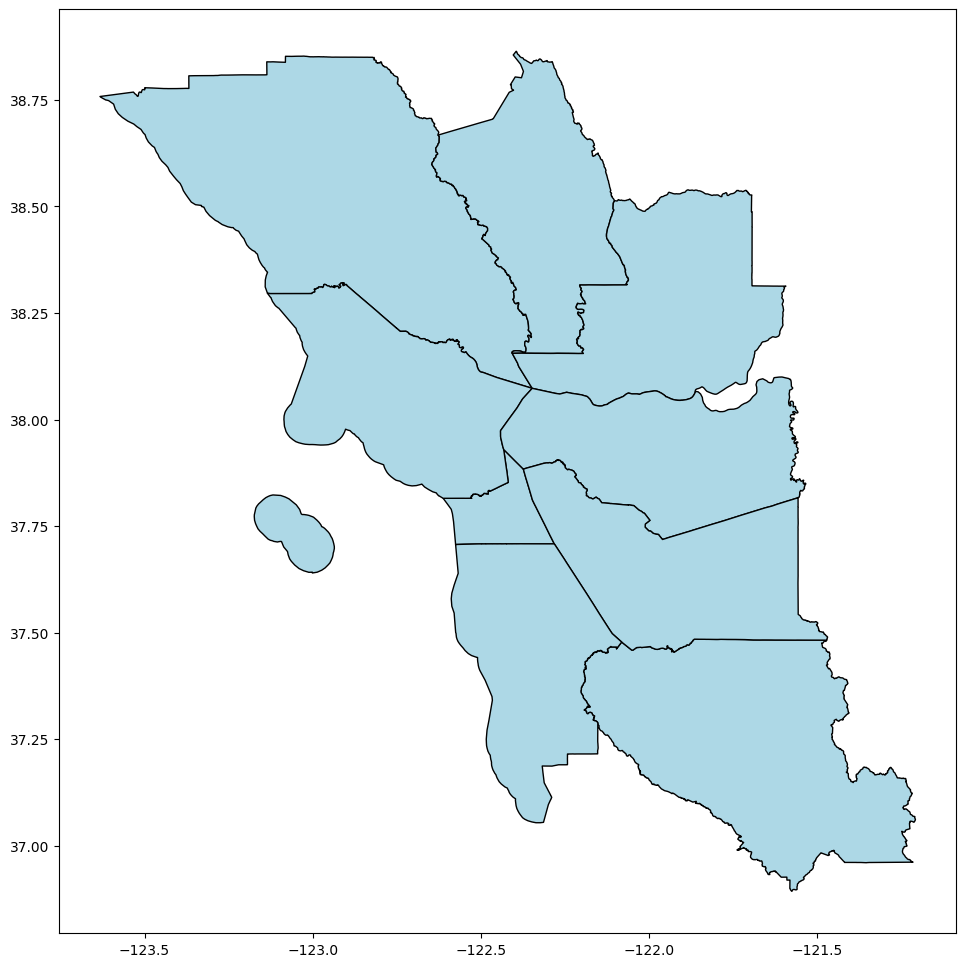

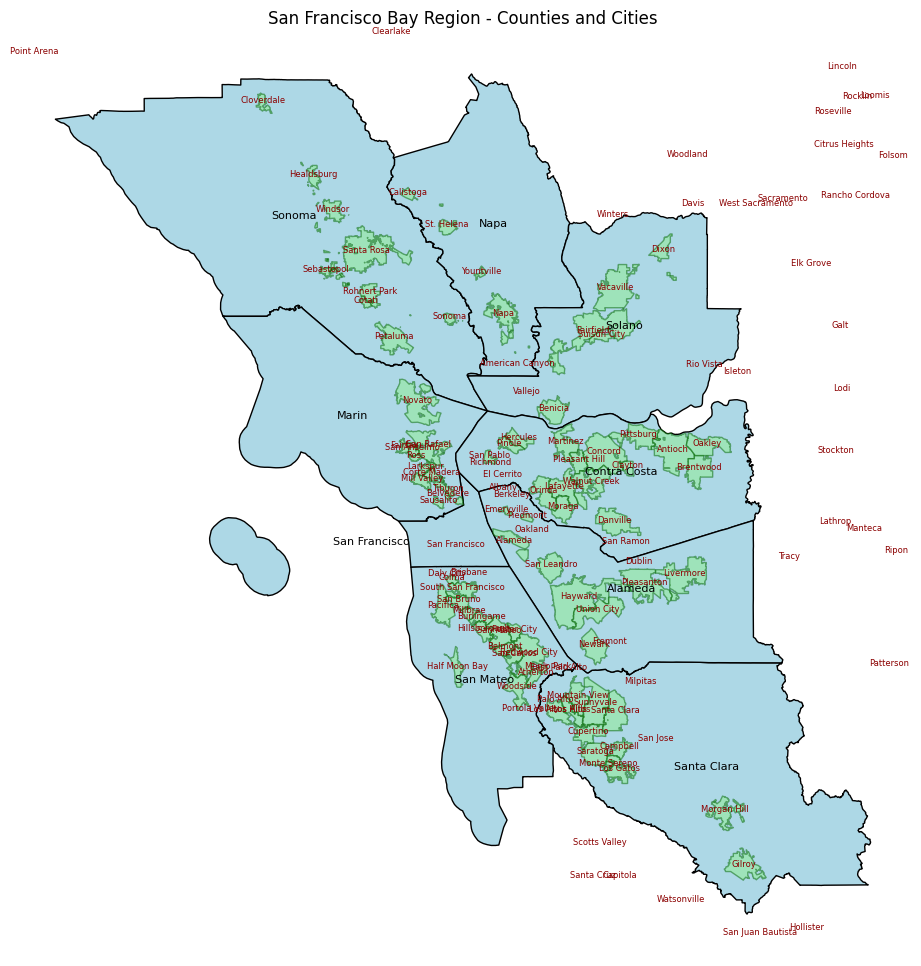

In [ ]:
cities = gpd.read_file('../data/raw/City_Boundaries/City_Boundaries.shp')
cities

print(cities.crs)
print(region_county.crs)

# CRS = Convert to same coordinate system
cities = cities.to_crs(region_county.crs)

# Plot counties
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
region_county.plot(ax=ax, color='lightblue', edgecolor='black')

# Perform a spatial join between cities and counties
# Keep only the cities that intersect with the counties in region_county
cities_within_counties = gpd.sjoin(cities, region_county, how="inner", op='within')

# Use cities_within_counties instead of cities
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
region_county.plot(ax=ax, color='lightblue', edgecolor='black')

# Overlay the cities that are within the county boundaries
cities_within_counties.plot(ax=ax, color='lightgreen', edgecolor='darkgreen', alpha=0.5)

# Annotate the county names
for idx, row in region_county.iterrows():
    ax.annotate(text=row['coname'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                horizontalalignment='center', fontsize=8, color='black')
    
# Add city names
for idx, row in cities.iterrows():
    ax.annotate(text=row['CITY'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                horizontalalignment='center', fontsize=6, color='darkred')

ax.set_title('San Francisco Bay Region - Counties and Cities')
ax.set_axis_off()
plt.show()
